# Loading

> Load data from spectral libraries.

In [ ]:
#| default_exp loading

In [ ]:
#| export
import fastcore.all as fc
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re

In [ ]:
#| exports
fname_ossl = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'

In [ ]:
#| exports
class OSSLLoader:
    "Load OSSL data and filter it by spectra type and analytes of interest."
    CFGS = {
        'visnir': {'ref_col': 'scan_visnir.1500_ref', 'range': [400, 2500]},
        'mir': {'ref_col': 'scan_mir.1500_abs', 'range': [600, 4000]}
    }
    
    DTYPE_DICT = {
        'id.layer_local_c': 'object',
        'id.location_olc_txt': 'object',
        'id.dataset.site_ascii_txt': 'object',
        'id.scan_local_c': 'object',
        'layer.texture_usda_txt': 'object',
        'pedon.taxa_usda_txt': 'object',
        'horizon.designation_usda_txt': 'object',
        'location.country_iso.3166_txt': 'object',
        'surveyor.address_utf8_txt': 'object',
        'efferv_usda.a479_class': 'object',
        'scan.mir.date.begin_iso.8601_yyyy.mm.dd': 'object',
        'scan.mir.date.end_iso.8601_yyyy.mm.dd': 'object',
        'scan.mir.model.name_utf8_txt': 'object',
        'scan.mir.model.code_any_txt': 'object',
        'scan.mir.method.optics_any_txt': 'object',
        'scan.mir.method.preparation_any_txt': 'object',
        'scan.mir.license.title_ascii_txt': 'object',
        'scan.mir.license.address_idn_url': 'object',
        'scan.mir.doi_idf_url': 'object',
        'scan.mir.contact.name_utf8_txt': 'object',
        'scan.mir.contact.email_ietf_txt': 'object',
        'scan.visnir.date.begin_iso.8601_yyyy.mm.dd': 'object',
        'scan.visnir.date.end_iso.8601_yyyy.mm.dd': 'object',
        'scan.visnir.model.name_utf8_txt': 'object',
        'scan.visnir.model.code_any_txt': 'object',
        'scan.visnir.method.optics_any_txt': 'object',
        'scan.visnir.method.preparation_any_txt': 'object',
        'scan.visnir.license.title_ascii_txt': 'object',
        'scan.visnir.license.address_idn_url': 'object',
        'scan.visnir.doi_idf_url': 'object',
        'scan.visnir.contact.name_utf8_txt': 'object',
        'scan.visnir.contact.email_ietf_txt': 'object'
    }

    def __init__(self, fname: Path = Path.home() / '.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz'):
        self.fname = fname
        self.df = None
        self.ds_name_encoder = LabelEncoder()

    def load_data(self, analytes: str|list, spectra_type: str = 'visnir', debug: bool = False):
        """Load OSSL data and filter it by spectra type and analytes of interest"""
        print(f'Loading data from {self.fname} ...')
        self.df = pd.read_csv(self.fname, dtype=self.DTYPE_DICT,
                              compression='infer', low_memory=True)

        if debug:
            return self.df

        analytes = [analytes] if isinstance(analytes, str) else analytes
        subset = analytes + [self.CFGS[spectra_type]['ref_col']]
        self.df = self.df.dropna(subset=subset, how='any')

        X = self._get_spectra(spectra_type)
        y = self.df[analytes].values
        smp_idx = self.df['id.layer_uuid_txt'].values
        ds_name = self._encode_dataset_names()
        X_names = self._get_wavelengths(spectra_type)

        return X, y, X_names, smp_idx, ds_name, self.ds_name_encoder.classes_

    def _get_spectra(self, spectra_type: str):
        cols_ref = [name for name in self.df.columns if f'scan_{spectra_type}.' in name]
        X = self.df[cols_ref].values
        lower_limit, upper_limit = self.CFGS[spectra_type]['range']
        X_names = self._get_wavelengths(spectra_type)
        idxs = np.where((X_names >= lower_limit) & (X_names <= upper_limit))[0]
        return X[:, idxs]

    def _encode_dataset_names(self):
        return self.ds_name_encoder.fit_transform(self.df['dataset.code_ascii_txt'])

    def _get_wavelengths(self, spectra_type: str):
        pattern = r"scan_{}\.(\d+)_".format(spectra_type)
        return np.array([int(re.search(pattern, name).group(1)) for name in self.df.columns
                         if re.search(pattern, name)])


Usage example:

In [ ]:
#| eval: false
loader = OSSLLoader()
analytes = 'k.ext_usda.a725_cmolc.kg'
X, y, wavenumbers, smp_idx, ds_name, ds_label = loader.load_data(analytes, 
                                                                 spectra_type='mir')

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'wavenumbers: {wavenumbers}')
print(f'smp_idx: {smp_idx}')
print(f'ds_name: {ds_name}')
print(f'ds_label: {ds_label}')

Loading data from /Users/franckalbinet/.lssm/data/ossl/ossl_all_L0_v1.2.csv.gz ...
X shape: (57674, 1701)
y shape: (57674, 1)
wavenumbers: [ 600  602  604 ... 3996 3998 4000]
smp_idx: ['3998362dd2659e2252cd7f38b43c9b1f' '2bab4dbbac073b8648475ad50d40eb95'
 '29213d2193232be8867d85dec463ec00' ... 'b790da349d49885c5727a2b5fd67b13d'
 'a057a7ead9eebce24d4039de7fd5e01b' '80bf4a0dc30f60552a38193d5c09b9cd']
ds_name: [0 0 0 ... 3 3 3]
ds_label: ['GARRETT.SSL' 'ICRAF.ISRIC' 'KSSL.SSL' 'LUCAS.WOODWELL.SSL']


In [ ]:
#| eval: false
#| hide
# For further testing, we save the first 10 samples of the dataset
n_samples = 10
fc.save_pickle('./files/spectrum-and-all.pkl', (X[:n_samples,:], y[:n_samples], wavenumbers, smp_idx[:n_samples], 
                                                ds_name[:n_samples], ds_label[:n_samples]))

In [ ]:
# class FukushimaLoader:

In [ ]:
#| exports
fname_fuku = '../_data/fk/Fukushimaall_Average.csv'

In [ ]:
#| eval: false
df_fuk = pd.read_csv(fname_fuku)

/var/folders/9w/q9wj71814bd5m3n9gpmxn1rm0000gn/T/ipykernel_19922/2972021314.py:2: DtypeWarning: Columns (10,15,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fuk = pd.read_csv(fname_fuku)


In [ ]:
#| eval: false
wn_cols = [col for col in df_fuk.columns if col.isdigit()]
non_wn_cols = [col for col in df_fuk.columns if col not in wn_cols]
print(wn_cols[:10])
print(f'from {wn_cols[0]} to {wn_cols[-1]}')

['650', '652', '654', '656', '658', '660', '661', '663', '665', '667']
from 650 to 4000


In [ ]:
#| eval: false
df_fuk[non_wn_cols].columns


Index(['Unnamed: 0', 'year', 'crops', 'soil_total_Cs134', 'soil_total_Cs137',
       'soil_ex_Cs137', 'exCs137_totalCs137', 'soil_water_soluble_K2O',
       'soil_ex_K2O', 'TF_plant_totalCs137', 'TF_plant_exCs137', 'soil_pH',
       'soil_C', 'soil_N', 'soil_CN_ratio', 'soil_CEC', 'soil_MgO', 'soil_CaO',
       'soil_P_absorption_coefficient', 'avaiable_Pi', 'course_sand',
       'fine_sand', 'silt', 'clay', 'Group.1'],
      dtype='object')

In [ ]:
#| eval: false
df_fuk[['soil_ex_K2O']]

,soil_ex_K2O
0,17.6
1,62.1
2,22.3
3,33.6
4,57.0
...,...
630,11.3
631,33.1
632,11.3
633,15.8


In [ ]:
# | exports
def load_mir_ring_trial(fname): return pd.read_csv(fname)

In [ ]:
# |eval: false
fname = Path().home() / \
    'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001/RT_STD_allMIRspectra_raw.csv'
df = load_mir_ring_trial(fname)
df.head()

,organization,sample_id,650,652,654,656,658,660,662,664,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,Agrocares,RT_01,1.97644,1.97292,1.97015,1.96778,1.96656,1.96609,1.96656,1.96773,...,1.09917,1.09898,1.09877,1.09851,1.09827,1.09811,1.09797,1.09797,1.09797,1.09797
1,Agrocares,RT_02,2.48977,2.50440,2.51282,2.51789,2.51765,2.51403,2.50914,2.50330,...,1.24065,1.24042,1.24015,1.23977,1.23938,1.23896,1.23861,1.23861,1.23861,1.23861
2,Agrocares,RT_03,2.63074,2.63082,2.63692,2.64624,2.64827,2.64566,2.63292,2.61260,...,1.25036,1.24959,1.24877,1.24777,1.24679,1.24585,1.24505,1.24505,1.24505,1.24505
3,Agrocares,RT_04,2.27312,2.26257,2.25124,2.23949,2.23315,2.23026,2.22792,2.22598,...,1.15192,1.15176,1.15158,1.15132,1.15106,1.15080,1.15058,1.15058,1.15058,1.15058
4,Agrocares,RT_05,2.26744,2.25584,2.24658,2.23859,2.23159,2.22521,2.22157,2.22000,...,1.16109,1.16106,1.16102,1.16095,1.16086,1.16070,1.16056,1.16056,1.16056,1.16056


In [ ]:
fname = Path().home() / \
    'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001/RT_wetchem_soildata.csv'
df = pd.read_csv(fname)
df.head()

,\tsample_id,source,clay_perc,pH_H20,carbon_tot_perc,carbon_org_perc,potassium_cmolkg,phosporus_mgkg
0,RT_01,KSSL,6.28199,4.8525,0.61170,0.61170,0.26906,5.59999
1,RT_02,KSSL,4.44442,4.5850,3.48602,3.48602,0.23349,19.28365
2,RT_03,KSSL,42.19991,4.2300,0.25716,0.25716,0.29109,NaN
3,RT_04,KSSL,17.10475,6.5300,1.97755,1.97755,0.49925,NaN
4,RT_05,KSSL,17.22985,6.4700,2.14765,2.13584,0.59977,NaN


In [ ]:
df[['potassium_cmolkg']]

,potassium_cmolkg
0,0.26906
1,0.23349
2,0.29109
3,0.49925
4,0.59977
...,...
65,2.83900
66,1.35813
67,0.87217
68,0.97703


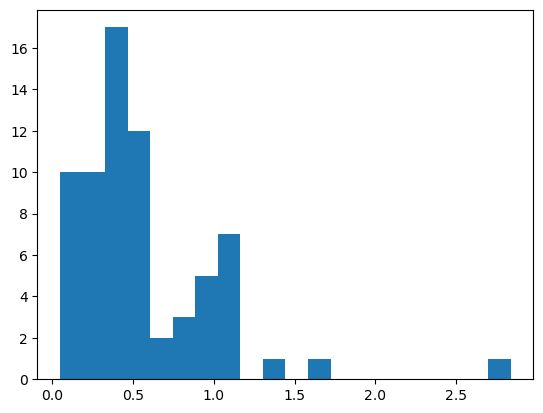

In [ ]:
from matplotlib import pyplot as plt

plt.hist(df['potassium_cmolkg'], bins=20);